<a href="https://colab.research.google.com/github/lorenzflow/Autoregressive-Convolutional-RNN/blob/main/Autoregressive_Convolutional_Recurrent_Neural_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect drive and some imports

In [1]:
# connect drive to save models after training
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install fastdtw

In [3]:
!pip install statsmodels

In [4]:
# library imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Conv1D, GRU, AveragePooling1D, Input, Concatenate, Add, Permute, Reshape, LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

#from statsmodels.tsa.arima.model import ARIMA

from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.arima_model import ARIMA

from scipy.spatial.distance import euclidean
from scipy.ndimage import gaussian_filter1d

from fastdtw import fastdtw

import re

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Implement prediction models

First a function to compile and fit tensorflow models. Early stopping with a validation split of 0.2 is used to prevent the models from overfitting.

Loss is mean squared error and the Adam optimiser is used for optimisation.

In [86]:
def compile_and_fit(model, X_train, y_train, patience=10, MAX_EPOCHS=1000, batch = 80):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(X_train, y_train, batch_size=batch, epochs=MAX_EPOCHS,
                      validation_split=0.2,
                      callbacks=[early_stopping])
  return history, model

## Simple LSTM

In [85]:
def fit_predict_LSTM(X_train, y_train, X_test, L=1, batch = 80):
  ''' Inputs:
      X_train and X_test are numpy arrays of the shape (num_train/test, time, features)
      L - the number of time steps to predict into the future

      Outputs:
      predicted array of shape (num_test, L, features)
      '''
      
  num_features = y_train.shape[-1]
  lstm_model = Sequential([
                  # Shape [batch, time, features] => [batch, time, lstm_units]
                  LSTM(32, return_sequences=False),
                  # Shape => [batch, L*features]
                  Dense(units = num_features*L),
                  Reshape((L, num_features))
                  ])
  
  _, lstm_model = compile_and_fit(lstm_model, X_train, y_train, batch = batch)
  predictions = lstm_model(X_test).numpy()
  return predictions


## SVM

In [7]:
def fit_predict_svm(X_train, y_train, X_test):
  regr = svm.SVR()
  regr.fit(X_train, y_train)
  predictions = regr.predict(X_test)
  return predictions


## ARIMA

How does it make sense to conmpare ARIMA to the other models?

Want to use cross validation, hence need different samples. So windowing makes sense, but then ARIMA does not allow windowing, or at least can not train an individual model for each window.

The code is included, but for now I left it out of the actual analysis.

In [8]:
def fit_predict_arima(X_train):
  model = ARIMA(X_train, order=(5,1,0))
  model_fit = model.fit()
  return model_fit.forecast()[0]

## Proposed Model
Implemented subclassing model class.
Technically the hyperparameters should be optimised here for example via bayesian optimisation. Sticking with the proposed cross validation approach in the paper this could be done with nested cross validation. Bayesian optimisation within nested cross validation would still require quite a bit of computing power so is skipped here (I have a small bayesian optimisation project on my github).

Two notes:
- For the linear prediction shortcut we use a dense layer on the permuted inputs so that the weigths are kept the same for each variable/feature.
- The multistep prediction is achieved by simply using a dense layer with L*num_features neurons and then reshaping. This is equivalent to each time step having it's own linear transformation.

In [9]:
class ACRNN(Model):

    def __init__(self, num_features, L, N_f=10, kernel_size=3, gru_units=5,):
        super(ACRNN, self).__init__()

        self.downsample05 = AveragePooling1D(pool_size=2, strides=2)
        self.downsample025 = AveragePooling1D(pool_size=4, strides=4)

        self.conv1_1 = Conv1D(N_f, kernel_size, strides=1, padding='causal',
                            data_format='channels_last', dilation_rate=1, groups=1,
                            activation='relu', use_bias=True, kernel_regularizer=None,
                            bias_regularizer=None)
        self.conv1_2 = Conv1D(N_f, kernel_size, strides=1, padding='causal',
                            data_format='channels_last', dilation_rate=1, groups=1,
                            activation='relu', use_bias=True, kernel_regularizer=None,
                            bias_regularizer=None)
        
        self.conv05_1 = Conv1D(N_f, kernel_size, strides=1, padding='causal',
                            data_format='channels_last', dilation_rate=1, groups=1,
                            activation='relu', use_bias=True, kernel_regularizer=None,
                            bias_regularizer=None)
        self.conv05_2 = Conv1D(N_f, kernel_size, strides=1, padding='causal',
                            data_format='channels_last', dilation_rate=1, groups=1,
                            activation='relu', use_bias=True, kernel_regularizer=None,
                            bias_regularizer=None)
        
        self.conv025_1 = Conv1D(N_f, kernel_size, strides=1, padding='causal',
                            data_format='channels_last', dilation_rate=1, groups=1,
                            activation='relu', use_bias=True, kernel_regularizer=None,
                            bias_regularizer=None)
        self.conv025_2 = Conv1D(N_f, kernel_size, strides=1, padding='causal',
                            data_format='channels_last', dilation_rate=1, groups=1,
                            activation='relu', use_bias=True, kernel_regularizer=None,
                            bias_regularizer=None)
        
        self.gru1 = GRU(gru_units, activation='tanh', recurrent_activation='sigmoid',
                        use_bias=True, kernel_regularizer=None,
                        recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                        dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False)
        self.gru05 = GRU(gru_units, activation='tanh', recurrent_activation='sigmoid',
                        use_bias=True, kernel_regularizer=None,
                        recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                        dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False)
        self.gru025 = GRU(gru_units, activation='tanh', recurrent_activation='sigmoid',
                        use_bias=True, kernel_regularizer=None,
                        recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                        dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False)
        
        self.concat = Concatenate()
      
        #note instead of L linear layers with j outputs have L*j and reshape
        self.w_rec = Dense(num_features*L, activation=None) # W_rec, output_shape (batch, features*L) 
        self.reshape_o = Reshape((L,num_features))

        self.permute_1 = Permute((2, 1)) #(batch, features, time) since want linear model to act on time for all features
        self.w_lin = Dense(L, activation=None) # W_lin (T,L), output_shape (batch, features, L)
        self.permute_2 = Permute((2, 1)) #(batch, L, features)

        self.add = Add()

    def call(self, inputs):
        G1 = self.conv1_2(self.conv1_1(inputs))
        G05 = self.conv05_2(self.conv05_1(self.downsample05(inputs)))
        G025 = self.conv025_2(self.conv025_1(self.downsample025(inputs)))

        h1 = self.gru1(G1)
        h05 = self.gru05(G05)
        h025 = self.gru025(G025)

        h = self.concat([h1, h05, h025])
        o = self.w_rec(h)
        o = self.reshape_o(o)
        l = self.permute_2(self.w_lin(self.permute_1(inputs[:,-5:,:]))) # select only last 5

        return self.add([o, l])

In [84]:
def fit_predict_acrnn(X_train, y_train, X_test, L=1, batch = 80):
  ''' Inputs:
      X_train and X_test are numpy arrays of the shape (num_train/test, time, features)
      
      Outputs:
      predicted array of shape (num_test, features)
      '''
      
  num_features = X_train.shape[2]
  acrnn_model = ACRNN(num_features, L = L)
  
  _, acrnn_model = compile_and_fit(acrnn_model, X_train, y_train, batch = batch)
  predictions = acrnn_model(X_test).numpy()
  return predictions

#### with functional api to plot model graph
Just to visualise the model and check the architecture

In [79]:
# test hear with functional api to plot model graph

input_shape = (20,4)# input shape of original time series (time, features)
num_features = input_shape[1]
N_f = 10 # number of filters
kernel_size = 2 # kernel size for conv1D
units = 5 # GRU units
L = 7 # number of predicted time steps ahead

inputs = Input(shape=input_shape)
# downsample
x1 = inputs
x2 = AveragePooling1D(pool_size=2, strides=2)(inputs)
x3 = AveragePooling1D(pool_size=4, strides=4)(inputs)

#causal convolutions (batch, time, features)
x1 = Conv1D(
    N_f, kernel_size, strides=1, padding='causal',
    data_format='channels_last', dilation_rate=1, groups=1,
    activation='relu', use_bias=True, kernel_regularizer=None,
    bias_regularizer=None)(x1)
x1 = Conv1D(
  N_f, kernel_size, strides=1, padding='causal',
  data_format='channels_last', dilation_rate=1, groups=1,
  activation='relu', use_bias=True, kernel_regularizer=None,
  bias_regularizer=None)(x1)

x2 = Conv1D(
    N_f, kernel_size, strides=1, padding='causal',
    data_format='channels_last', dilation_rate=1, groups=1,
    activation='relu', use_bias=True, kernel_regularizer=None,
    bias_regularizer=None)(x2)
x2 = Conv1D(
    N_f, kernel_size, strides=1, padding='causal',
    data_format='channels_last', dilation_rate=1, groups=1,
    activation='relu', use_bias=True, kernel_regularizer=None,
    bias_regularizer=None)(x2)

x3 = Conv1D(
    N_f, kernel_size, strides=1, padding='causal',
    data_format='channels_last', dilation_rate=1, groups=1,
    activation='relu', use_bias=True, kernel_regularizer=None,
    bias_regularizer=None)(x3)
x3 = Conv1D(
    N_f, kernel_size, strides=1, padding='causal',
    data_format='channels_last', dilation_rate=1, groups=1,
    activation='relu', use_bias=True, kernel_regularizer=None,
    bias_regularizer=None)(x3)


# GRU
h1 = GRU(
    units, activation='tanh', recurrent_activation='sigmoid',
    use_bias=True, kernel_regularizer=None,
    recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False)(x1)
h2 = GRU(
    units, activation='tanh', recurrent_activation='sigmoid',
    use_bias=True, kernel_regularizer=None,
    recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False)(x2)
h3 = GRU(
    units, activation='tanh', recurrent_activation='sigmoid',
    use_bias=True, kernel_regularizer=None,
    recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False)(x3)

# concatenate GRU last hidden states
h = Concatenate()([h1, h2, h3]) # output_shape = (batch, units*3)
o_t = Dense(num_features*L, activation=None)(h) # W_rec, output_shape (batch, features*L)
o_t = Reshape((L,num_features))(o_t)
inputs_permuted = Permute((2, 1))(inputs[:,-5:,:]) #permute to (batch, features, time)
l = Dense(L, activation=None)(inputs_permuted) # W_lin (T,L), output_shape (batch, features, L)
l = Permute((2,1))(l)
outputs = Add()([o_t, l])
model = Model(inputs, outputs)

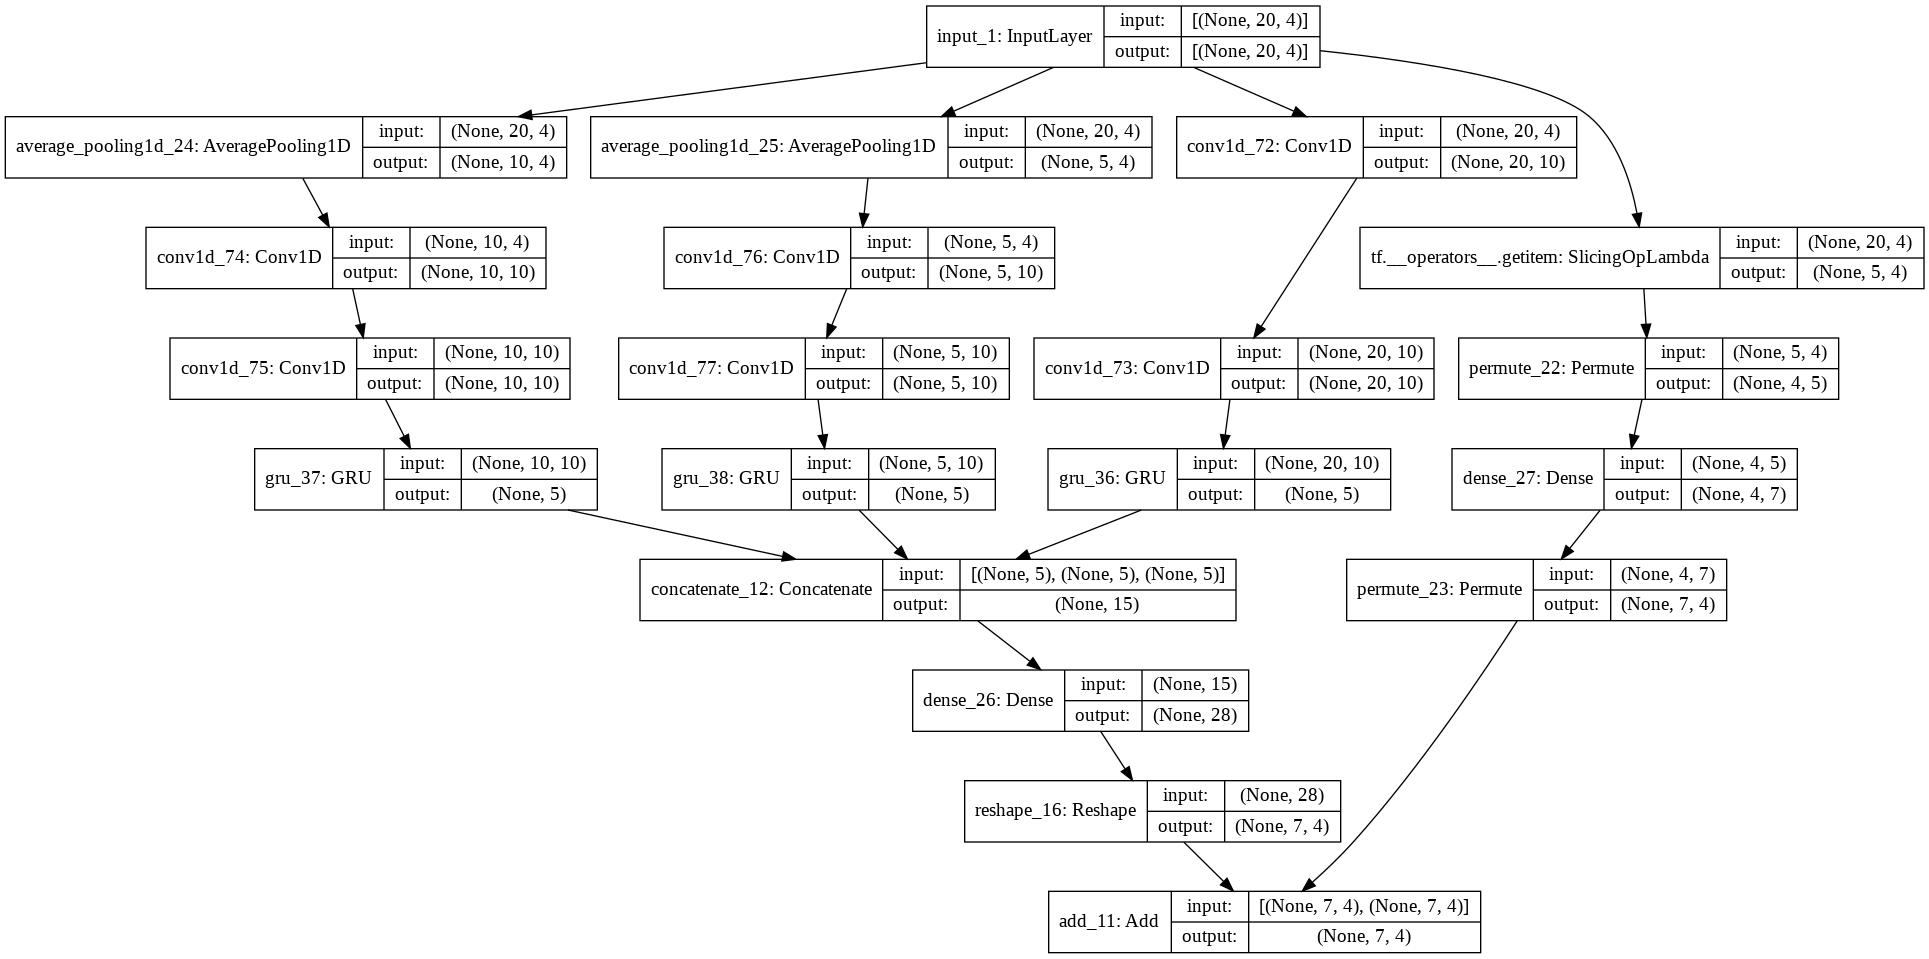

In [80]:
tf.keras.utils.plot_model(
    model, show_shapes=True)

## Function to run cross validation for given data set

In [11]:
# function to compute dwt for each sample and return average distance
def array_dtw(true, predicted):
  distance = np.zeros((true.shape[0],))
  for i in range(true.shape[0]):
    distance[i] = fastdtw(true[i,:,:] , predicted[i,:,:], dist=euclidean)[0]
  return np.mean(distance)

In [148]:
array_dtw(np.random.normal(size=(20,3,1)), np.random.normal(size=(20,3,1)))

3.1506551782294

In [83]:
def k_fold_cv(k, X, y, batch_size=80):
  '''
  Inpuits:
  X - numpy array containing observed window of shape (num_samples, time, features), note time = 0 mode 4
  y - numpy array containing target of shape (num_samples, L, features) ### potentially add L here if want to but does not make sense atm

  Outputs:
  dictionary: saving average test mse, mae and dtw for each model
  '''
  L = y.shape[1]
  # create folds
  kf = KFold(n_splits=k)
  kf.get_n_splits(X)
  predictions = {}
  mse = {}
  mae = {}
  dtw = {}
    


  # loop over folds
  for train_index, test_index in kf.split(X):
      
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      predictions['lstm'] = fit_predict_LSTM(X_train, y_train, X_test, L=L, batch = batch_size)
      predictions['acrnn'] = fit_predict_acrnn(X_train, y_train, X_test, L=L, batch = batch_size)
      
      # other svm and arima for one step and additional metrics mse & mae
      if L == 1:
        predictions['svm'] = fit_predict_svm(X_train.squeeze(), y_train.squeeze(), X_test.squeeze())
        y_test = y_test.squeeze()
        #predictions['arima'] = fit_predict_arima(X_train, y_train, X_test)
        for key in predictions:
          if key in mse: # if already have a loss value, append to list
            mse[key].append(mean_squared_error(y_test , predictions[key].squeeze()))
            mae[key].append(mean_absolute_error(y_test , predictions[key].squeeze()))
          else: # else create entry in dictionary
            mse[key] = [mean_squared_error(y_test , predictions[key].squeeze())]
            mae[key] = [mean_absolute_error(y_test , predictions[key].squeeze())]

      # dtw for multistep
      else:
        for key in predictions:
          if key in dtw:
            dtw[key].append(array_dtw(y_test , predictions[key]))
          else:
            dtw[key] = [array_dtw(y_test , predictions[key])]

  if L==1:
    return mse, mae
  else:
    return dtw

# Experiments

## Univariate

### Load data sets and standardise plus smoothing

In [15]:
sunspots = pd.read_csv('/content/drive/My Drive/DFKI_task/sunspot.csv', header=None, sep=';')
melbourne = pd.read_csv('/content/drive/My Drive/DFKI_task/melbourne.csv', error_bad_lines=False)

b'Skipping line 3653: expected 2 fields, saw 3\n'


In [16]:
melbourne.head()

,Date,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [17]:
sunspots.head()

,0,1,2,3,4,5,6
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


In [19]:
data = (sunspots[3] - np.mean(sunspots[3]))/np.std(sunspots[3])
sunspot_data = gaussian_filter1d(data, sigma=1) # calculate in time axis

temp = melbourne['Daily minimum temperatures in Melbourne, Australia, 1981-1990'] # extract temperature column
temp = [float(re.sub('\D', '', x)) for x in temp] # remove unwanted characters and type to float
data = (temp - np.mean(temp))/np.std(temp) # standatdise
melbourne_data = gaussian_filter1d(data, sigma=1) # gaussian filter

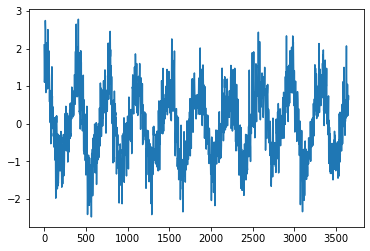

In [20]:
plt.plot(melbourne_data)

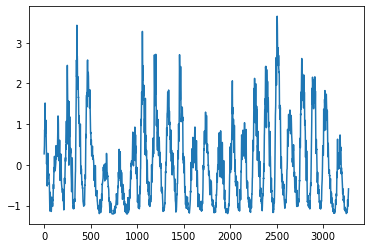

In [21]:
plt.plot(sunspot_data)

### Single step
Here the 5 fold CV for the one-step prediction in the univariate case is performed.

In [28]:
# iterate window extractor over time series:
def window_generator(timeseries,window_width, target_width):
  '''
  inputs:
  timeseries - (time, features) array

  outputs X, y
  X - (num_samples, window_width, features) array with windows of width window_width over time series
  y - (num_samples, target_width, features) array with target windows of width target_width over time series
  '''
  X = []
  y = []

  for i in range(len(timeseries) - window_width - target_width):

    x_i, y_i = list(timeseries[i:(window_width+i)]), list(timeseries[(window_width+i):(window_width+target_width+i)])
    X.append(x_i)
    y.append(y_i)

  X = np.array(X)
  y = np.array(y)
  # add feature dimension (on variable)
  X = np.expand_dims(X,-1)
  y = np.expand_dims(y,-1)
  return X, y

Now we need to generate the windows to train our models on. Even though it would make sense to for example consider years for the melbourne temperature data as different windows this would lead to too few samples. Hence just choose 15 here.

In [103]:
# choose window width 15
X_sunspot, y_sunspot = window_generator(sunspot_data, 15, 1)
X_melbourne, y_melbourne = window_generator(melbourne_data, 15, 1)

In [ ]:
sunspot_mse, sunspot_mae = k_fold_cv(5, X_sunspot, y_sunspot)

In [128]:
sunspot_mse_mean = {}
sunspot_mse_std = {}
sunspot_mae_mean = {}
sunspot_mae_std = {}
for key in sunspot_mse:
  sunspot_mse_mean[key] = np.mean(sunspot_mse[key])
  sunspot_mse_std[key] = np.std(sunspot_mse[key])
  sunspot_mae_mean[key] = np.mean(sunspot_mae[key])
  sunspot_mae_std[key] = np.std(sunspot_mae[key])



In [132]:
print('Sunspot data one-step forecast')
print('MSE mean',sunspot_mse_mean)
print('MSE standard deviation',sunspot_mse_std)
print('MAE mean',sunspot_mae_mean)
print('MAE standard deviation',sunspot_mae_std)

Sunspot data one-step forecast
MSE mean {'lstm': 0.005475353931225291, 'acrnn': 0.007764696430548672, 'svm': 0.01634586902308793}
MSE standard deviation {'lstm': 0.0007160980350206417, 'acrnn': 0.0012334147853222137, 'svm': 0.009380785420467096}
MAE mean {'lstm': 0.053070497144560205, 'acrnn': 0.06257292182688544, 'svm': 0.08538936524610245}
MAE standard deviation {'lstm': 0.0037258542755208984, 'acrnn': 0.004865814564924724, 'svm': 0.013938606832557312}


The obtained results for the LSTM are comparable to the paper. The other methods seem to perform significantly better than in the paper. This could be due to the window generator applied. Unfortunately, the exact approach taken in the paper is not clear. Perform the same for the melbourne temperature data set.

In [ ]:
melbourne_mse, melbourne_mae = k_fold_cv(5, X_melbourne, y_melbourne)

In [137]:
melbourne_mse_mean = {}
melbourne_mse_std = {}
melbourne_mae_mean = {}
melbourne_mae_std = {}
for key in sunspot_mse:
  melbourne_mse_mean[key] = np.mean(melbourne_mse[key])
  melbourne_mse_std[key] = np.std(melbourne_mse[key])
  melbourne_mae_mean[key] = np.mean(melbourne_mae[key])
  melbourne_mae_std[key] = np.std(melbourne_mae[key])

In [139]:
print('Melbourne data one-step forecast')
print('MSE mean',melbourne_mse_mean)
print('MSE standard deviation',melbourne_mse_std)
print('MAE mean', melbourne_mae_mean)
print('MAE standard deviation', melbourne_mae_std)

Melbourne data one-step forecast
MSE mean {'lstm': 0.014721380147303805, 'acrnn': 0.016816547238573103, 'svm': 0.030104060630810493}
MSE standard deviation {'lstm': 0.001117957873934108, 'acrnn': 0.0017097290598042136, 'svm': 0.007382839846417508}
MAE mean {'lstm': 0.09525189222994247, 'acrnn': 0.10196955306837985, 'svm': 0.13287549167285828}
MAE standard deviation {'lstm': 0.0029123193784164427, 'acrnn': 0.005101986708135864, 'svm': 0.014263983001735607}


Similar results as in paper.

### Univariate multi-step prediction


In [ ]:
X, y = window_generator(sunspot_data, 15, 3)
dtw = k_fold_cv(5, X, y)
dtw_mean = {}
dtw_std = {}

In [37]:
for key in dtw:
    dtw_mean[key] = np.mean(dtw[key])
    dtw_std[key] = np.std(dtw[key])
print('sunspot', 'data ', 3 ,'- step forecast')
print('dtw mean',dtw_mean)
print('dtw standard deviation',dtw_std)

sunspot data  3 - step forecast
dtw mean {'lstm': 0.3841536466279474, 'acrnn': 0.40164894998407463}
dtw standard deviation {'lstm': 0.030904727348550914, 'acrnn': 0.0303703395226645}


In [38]:
def multi_step(data, steps, dataname):
  # choose window width 15
  X, y = window_generator(data, 15, steps)
  dtw = k_fold_cv(5, X, y)
  dtw_mean = {}
  dtw_std = {}
  
  for key in dtw:
    dtw_mean[key] = np.mean(dtw[key])
    dtw_std[key] = np.std(dtw[key])
  print(dataname, 'data ', steps ,'-step forecast')
  print('dtw mean',dtw_mean)
  print('dtw standard deviation',dtw_std)
  return dtw, dtw_mean, dtw_std

  

In [ ]:
# run multistep forecast for all stepsizes
multistep = [3,5,7]
mean_dict = {}
std_dict = {}
for step in multistep:
  _, dtw_mean, dtw_std = multi_step(sunspot_data, step, 'sunspot')
  mean_dict[step] = dtw_mean
  std_dict[step] = dtw_std

## Multivariate

### Single step

For the photovoltaic data set it would be reasonable to dicard the night time. However, this would lead to sequences of different lengths as sunsrise/sunset changes so not as straight forward (would have to cut to equal length), also depends on the window width

In [62]:
import glob
file_dir='./drive/My Drive/DFKI_task/solar'
file_names = glob.glob('{}/*'.format(file_dir))

def get_data(file_names=file_names):
  data = map(pd.read_csv, file_names)
  data = [np.array(d['Power(MW)']) for d in data]
  return np.stack(data, axis=1)

In [63]:
solar = get_data(file_names[:10])

In [69]:
solar_data = (solar - np.mean(solar, axis=0))/np.std(solar, axis=0)
solar_data = gaussian_filter1d(solar_data, sigma=1, axis=0)

In [80]:
# choose window width 15
X_solar, y_solar = window_generator(solar_data, 150, 1)
X_solar = X_solar.squeeze()
y_solar = y_solar.squeeze()

In [ ]:
solar_mse, solar_mae = k_fold_cv(5, X_solar, y_solar)

This is very slow unfortunately, and I underestimated the runtime so did not have time to finish running the experiments.